In [1]:
import pandas as pd
import torch.nn.functional as F
from torch.optim import Adam, SGD
from matplotlib import pyplot
from keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from torch.autograd import Variable
import torchvision.transforms as transforms
import torchvision
from tensorflow.keras import layers
from tensorflow import keras
from matplotlib import pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model, Model
from sklearn.preprocessing import MinMaxScaler

In [2]:
(trainX, trainy), (testX, testy) = cifar10.load_data()

In [3]:
trainy = to_categorical(trainy)
testy = to_categorical(testy)

In [4]:
trainX = trainX.astype('float32') / 255 
testX = testX.astype('float32') / 255

In [ ]:
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True, vertical_flip=False)
# prepare iterator
it_train = datagen.flow(trainX, trainy, batch_size=64)

In [ ]:
trainX.shape

(50000, 32, 32, 3)

In [ ]:
model = keras.Sequential(
    [
     keras.Input(shape = (32, 32, 3)), 
     layers.Conv2D(16, kernel_size = (3, 3),strides=(1,1),padding='same',activation='relu',name="c3-16"),
     layers.Conv2D(16, kernel_size = (3, 3),strides=(1,1),padding='same',activation='relu',name="c16-16"),
     layers.MaxPooling2D(pool_size = (2, 2),strides=(2, 2),name="mp1"),
     layers.Conv2D(32, kernel_size = (3, 3),strides=(1,1),padding='same',activation='relu',name="c16-32"),
     layers.Conv2D(32, kernel_size = (3, 3),strides=(1,1),padding='same',activation='relu',name="c32-32"),
     layers.MaxPooling2D(pool_size = (2, 2),strides=(2, 2),name="mp2"),
     layers.Conv2D(64, kernel_size = (3, 3),strides=(1,1),padding='same',activation='relu',name="c32-64"),
     layers.Conv2D(64, kernel_size = (3, 3),strides=(1,1),padding='same',activation='relu',name="c64-64"),
     layers.MaxPooling2D(pool_size = (2, 2),strides=(2, 2),name="mp3"),
     layers.Conv2D(128, kernel_size = (3, 3),strides=(1,1),padding='same',activation='relu',name="c64-128"),
     layers.Conv2D(128, kernel_size = (3, 3),strides=(1,1),padding='same',activation='relu',name="c128-128"),
     #stride = input // output   4
#kernel = input_size - (output_size-1)*stride  
#Padding = 0
     layers.AveragePooling2D(pool_size = (4, 4),strides=(4, 4),name="aap"),
     layers.Flatten(),
     layers.Dense(10, activation = 'softmax')
    ]
)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 c3-16 (Conv2D)              (None, 32, 32, 16)        448       
                                                                 
 c16-16 (Conv2D)             (None, 32, 32, 16)        2320      
                                                                 
 mp1 (MaxPooling2D)          (None, 16, 16, 16)        0         
                                                                 
 c16-32 (Conv2D)             (None, 16, 16, 32)        4640      
                                                                 
 c32-32 (Conv2D)             (None, 16, 16, 32)        9248      
                                                                 
 mp2 (MaxPooling2D)          (None, 8, 8, 32)          0         
                                                                 
 c32-64 (Conv2D)             (None, 8, 8, 64)          1

In [ ]:
epochs = 20
opt = keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss = 'categorical_crossentropy',
              optimizer = opt,
              metrics = ['accuracy'])
#history = model.fit(trainX, trainy, batch_size = batch_size, epochs = epochs, validation_split = 0.2)

steps = int(trainX.shape[0] / 64)
history = model.fit(it_train, steps_per_epoch=steps, epochs=epochs, validation_data=(testX, testy))


In [ ]:
model.save('./Q2A.h5')

In [8]:
model = load_model('./Q2A.h5') 

In [ ]:
scores = model.evaluate(testX, testy)
print('Test accuracy:', scores[1])

313/313 [==============================] - 11s 34ms/step - loss: 0.6484 - accuracy: 0.8234
Test accuracy: 0.8234000205993652


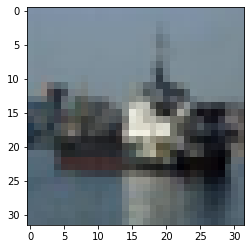

In [ ]:
plt.imshow(trainX[40001])
plt.show()

In [9]:
layer_outputs = [layer.output for layer in model.layers] 
# Creates a model that will return these outputs, given the model input
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(trainX[40000:,:]) 


In [ ]:
layer_names = []
for layer in model.layers[:]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
print(layer_names[:-2])
len(activations)

['c3-16', 'c16-16', 'mp1', 'c16-32', 'c32-32', 'mp2', 'c32-64', 'c64-64', 'mp3', 'c64-128', 'c128-128', 'aap']


14

Activation values for one data image

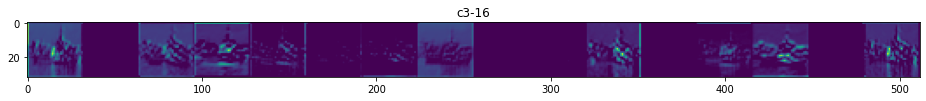

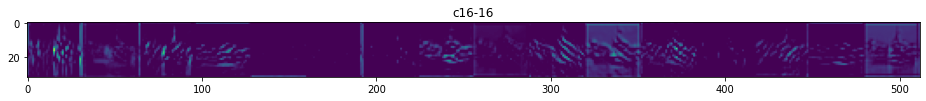

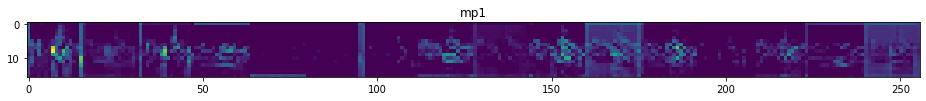

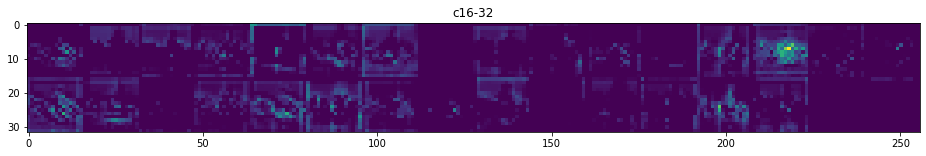

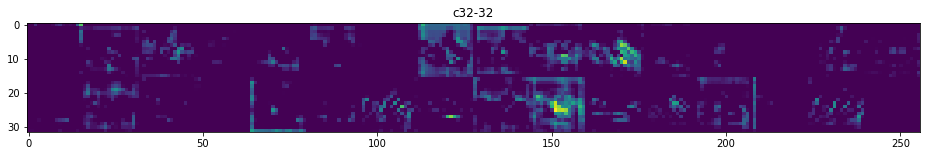

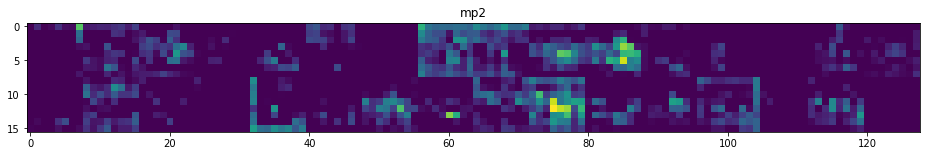

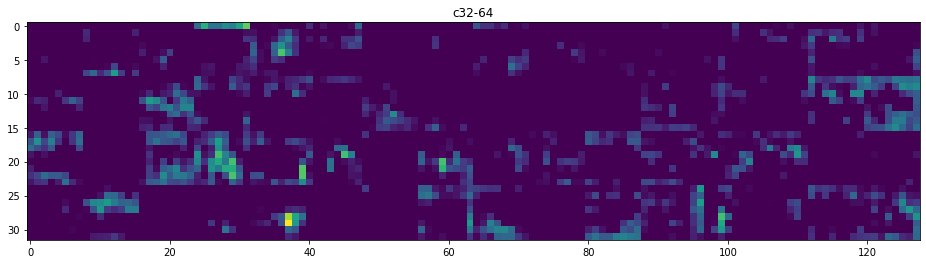

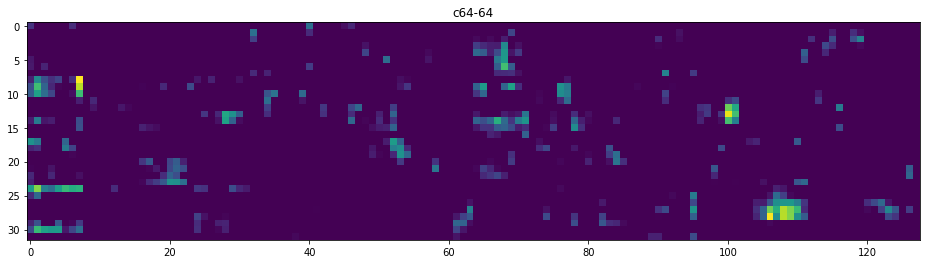

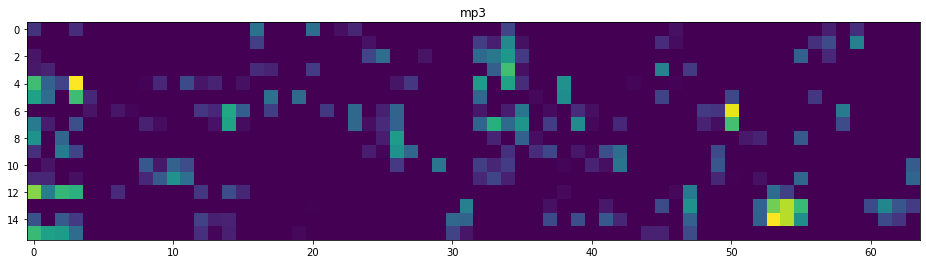

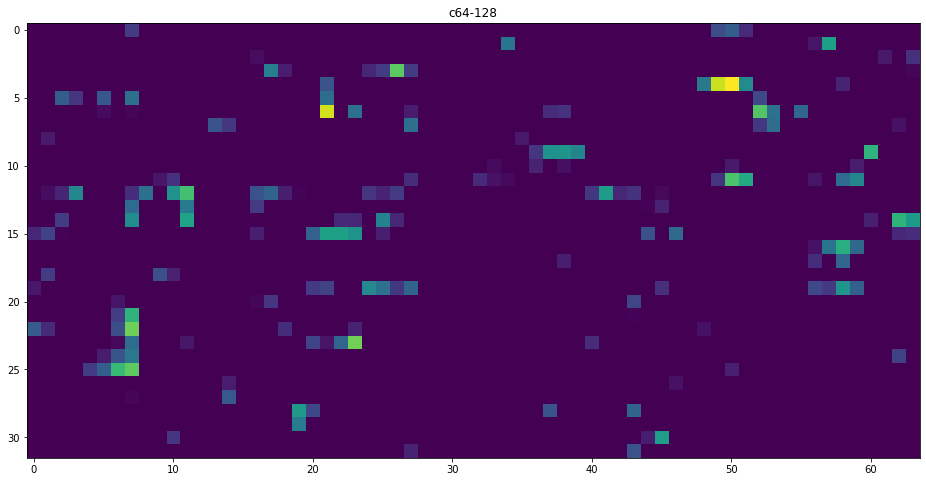

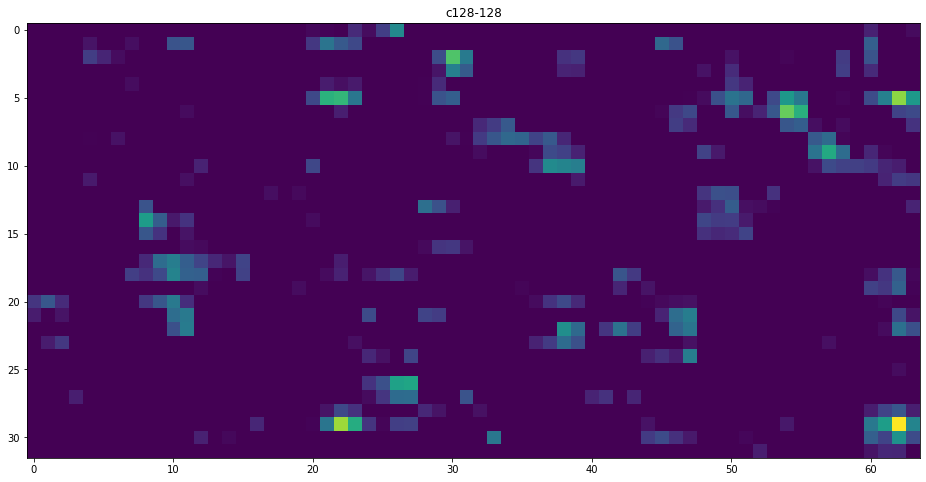

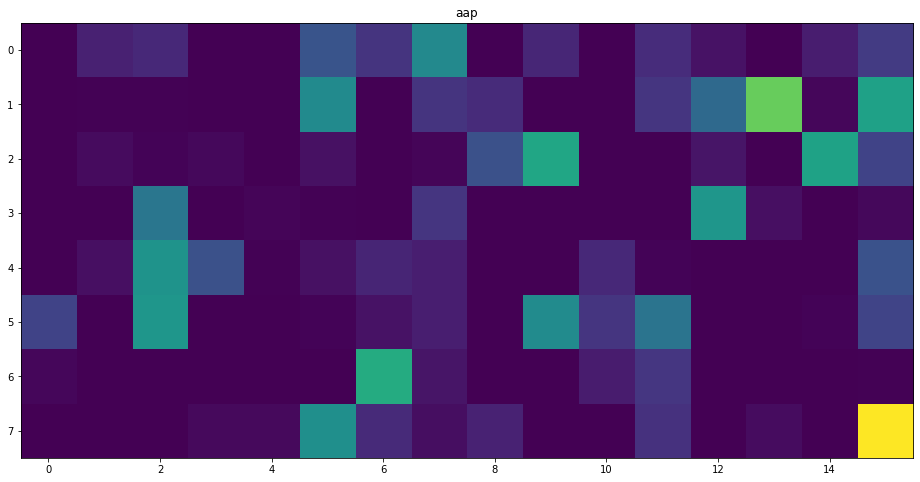

In [ ]:
images_per_row = 16
for layer_name, layer_activation in list(zip(layer_names, activations))[:-2]:#zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
          channel_image = layer_activation[1,:, :,col * images_per_row + row]
          channel_image *= 64
          channel_image += 128
          display_grid[col * size : (col + 1) * size, # Displays the grid
                       row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

average absolute values of activations

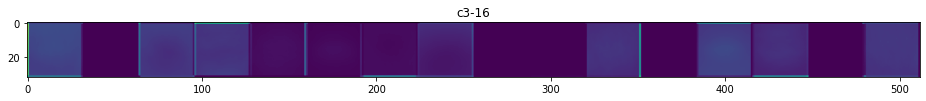

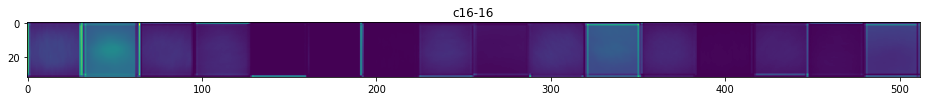

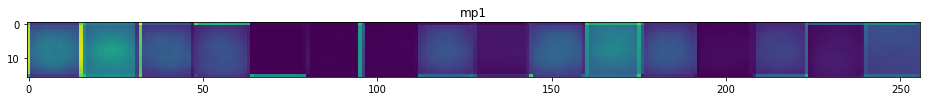

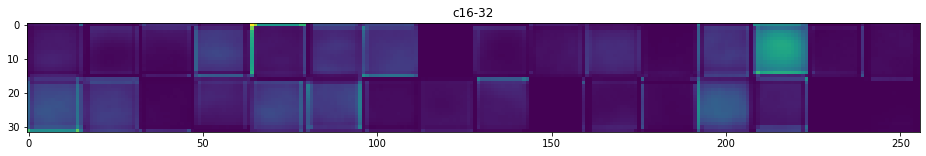

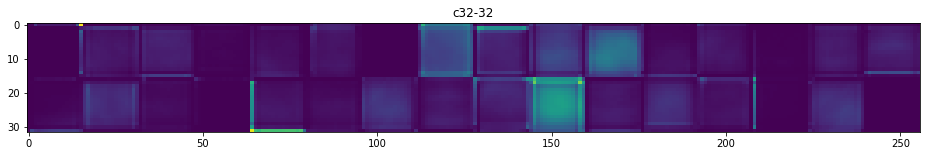

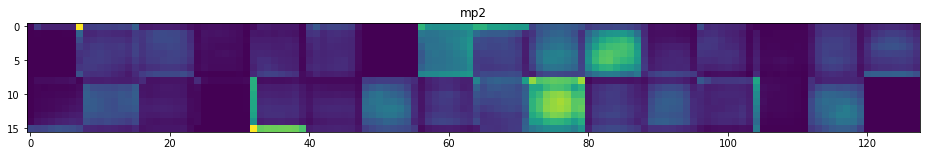

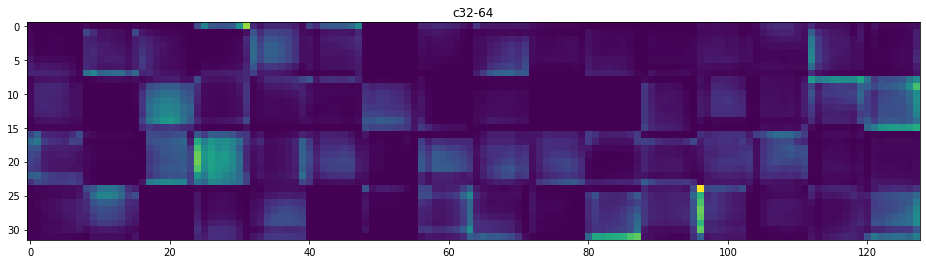

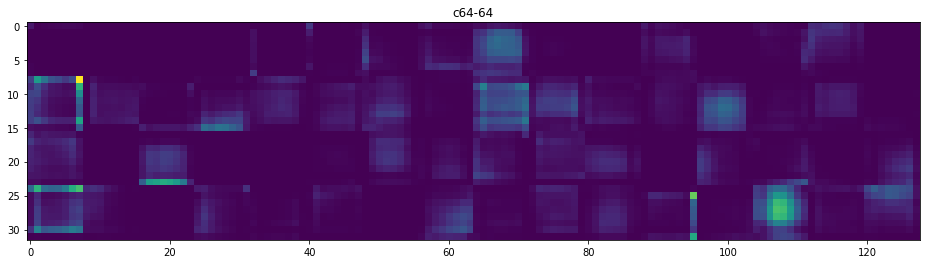

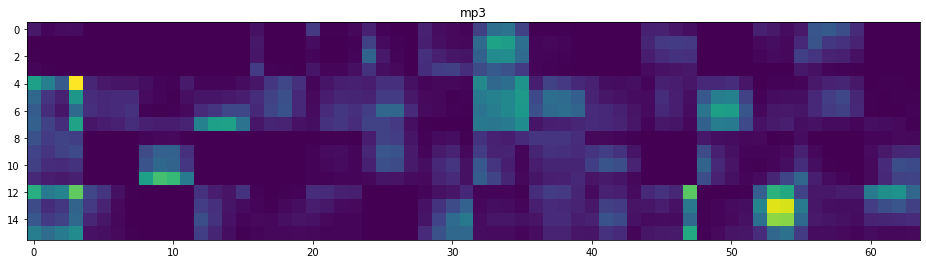

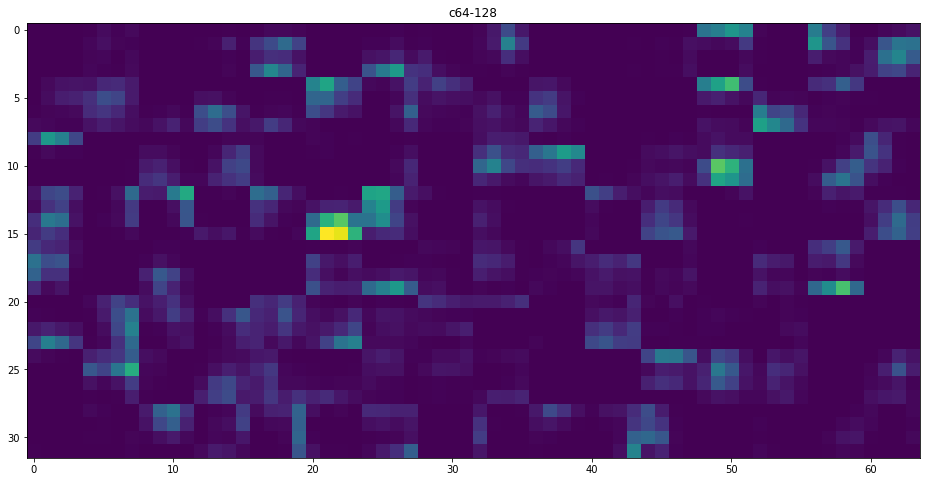

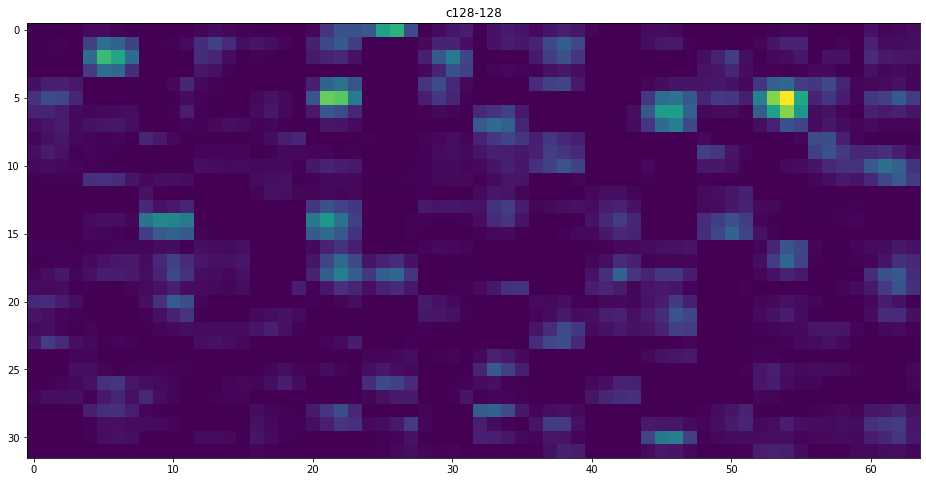

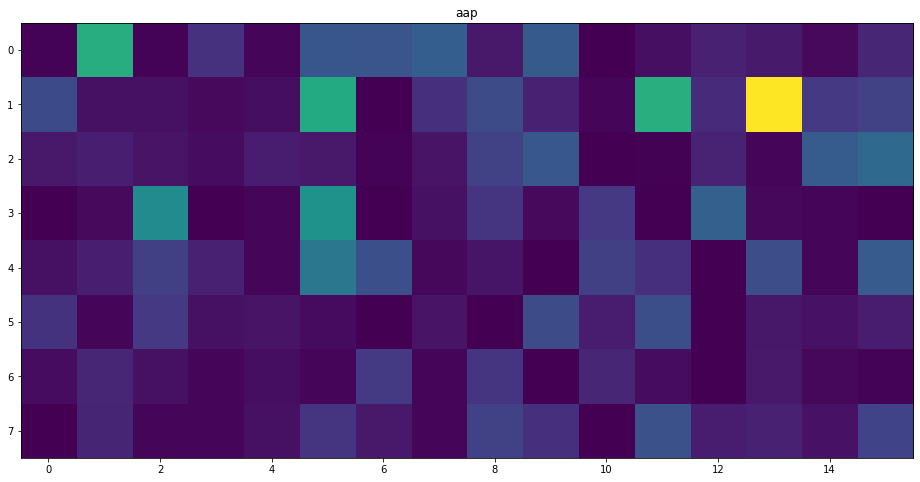

In [ ]:
layer_names = []
for layer in model.layers[:]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
images_per_row = 16
for layer_name, layer_activation in list(zip(layer_names, activations))[:-2]: # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
          channel_image=0
          for i in range(len(layer_activation)):
            channel_image += layer_activation[i,:, :,col * images_per_row + row]
          channel_image *= 64
          channel_image += 128 
          display_grid[col * size : (col + 1) * size, # Displays the grid
                       row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [10]:
normalized_activation=[]
for layer_activation in activations:
  print(layer_activation.shape)
  normalized_activation.append(np.mean(np.absolute(layer_activation.flatten())))
print(normalized_activation)
scaler = MinMaxScaler()
normalized_activation=scaler.fit_transform(np.array(normalized_activation).reshape(-1, 1))


(10000, 32, 32, 16)
(10000, 32, 32, 16)
(10000, 32, 32, 16)
(10000, 32, 32, 16)
(10000, 16, 16, 16)
(10000, 16, 16, 32)
(10000, 16, 16, 32)
(10000, 16, 16, 32)
(10000, 16, 16, 32)
(10000, 8, 8, 32)
(10000, 8, 8, 64)
(10000, 8, 8, 64)
(10000, 8, 8, 64)
(10000, 8, 8, 64)
(10000, 4, 4, 64)
(10000, 4, 4, 128)
(10000, 4, 4, 128)
(10000, 4, 4, 128)
(10000, 4, 4, 128)
(10000, 1, 1, 128)
(10000, 128)
(10000, 10)
[0.07142792, 0.0713925, 0.06081062, 0.06078008, 0.12590678, 0.10976074, 0.10970587, 0.14371955, 0.14364763, 0.3239759, 0.42546284, 0.42525053, 0.5743603, 0.5740731, 1.5217301, 1.3017586, 1.3011086, 1.431678, 1.4309622, 1.4309614, 1.4309614, 0.1]


In [15]:
pd.DataFrame(zip(layer_names, normalized_activation[:,0]), columns = ['Layer', 'average absolute values of activations'])

,Layer,average absolute values of activations
0,c3-16,0.007288
1,batch_normalization,0.007264
2,c16-16,0.000021
3,batch_normalization_1,0.000000
4,mp1,0.044578
5,c16-32,0.033527
6,batch_normalization_2,0.033489
7,c32-32,0.056771
8,batch_normalization_3,0.056722
9,mp2,0.180154
